In [ ]:
# !pip install facenet_pytorch

# Eye tracking principals

For each frame:
  1. Using the MTCNN model to determine approximate eye positions.
  2. Identification of rough ROI based on average facial proportions.
  3. Using Canny's algorithm to determine the boundaries and edjes of the eye.
  4. Refining the ROI based on the minimum and maximum values ​​of Canny boundaries.
  5. Finding cornea from Canny's map of edges.
  6. Calculating eye vector (direction of the view) as difference between box-center and center of the estimated cornea.
  7. Mapping eye vector to the screen point.

In [ ]:
import math
import numpy as np

import torch
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Main functions

Backbone MTCNN model

In [ ]:
# Initialize MTCNN model
mtcnn = MTCNN(keep_all=True)

Image preprocessing

In [ ]:
# Initial image preprocessing
def image_preproc(image, color, blurfilter):
  # Convert BGR to RGB or gray
  if color == 'rgb':
    preproc_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  elif color == 'gray':
    preproc_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    ValueError()

  # Gaussian blur
  preproc_image = cv2.GaussianBlur(preproc_image, blurfilter, 0)

  return preproc_image

Rough Eyes ROI

In [ ]:
# Function for detecting eye-centers
def eyes_bounds(image):
  # Detect faces and landmarks
  boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

  # Drawing centers and potential cornea square
  if landmarks is not None:
        for landmark in landmarks:
            # Get the coordinates for the eyes
            left_eye = landmark[0]
            right_eye = landmark[1]

            # Predicting boundbox size
            r_ee = abs(left_eye[0] - right_eye[0])
            k_e_x = 30/63 #ratio between avg x lengh of eye and avg distance between eyes
            k_e_y = 25/63 #ratio between avg y lengh of eye and avg distance between eyes
            h_e_x = (r_ee * 1.25) * k_e_x / 2
            h_e_y = (r_ee * 1) * k_e_y / 2

            bounded_image = image.copy()

            # Centers
            cv2.drawMarker(bounded_image, (int(left_eye[0]), int(left_eye[1])), color = (255, 0, 0), markerType = cv2.MARKER_CROSS, markerSize = 5, thickness = 2)
            cv2.drawMarker(bounded_image, (int(right_eye[0]), int(right_eye[1])), color = (255, 0, 0), markerType = cv2.MARKER_CROSS, markerSize = 5, thickness = 2)

            # Draw bounding box around the eye center
            cv2.rectangle(bounded_image, (int(left_eye[0] - (h_e_x)), int(left_eye[1] - (h_e_y-5))), (int(left_eye[0] + (h_e_x)), int(left_eye[1] + (h_e_y+5))), (255, 0, 0), 2)
            cv2.rectangle(bounded_image, (int(right_eye[0] - (h_e_x)), int(right_eye[1] - (h_e_y-5))), (int(right_eye[0] + (h_e_x)), int(right_eye[1] + (h_e_y+5))), (255, 0, 0), 2)

  return bounded_image, left_eye, right_eye, h_e_x, h_e_y, r_ee

# Function for brut cropping ROI of the eyes
def eye_ROI(image, eye_cord, h_eye_x, h_eye_y):

    x_min = int(eye_cord[0] - (h_eye_x))
    x_max = int(eye_cord[0] + (h_eye_x))
    y_min = int(eye_cord[1] - (h_eye_y-5))
    y_max = int(eye_cord[1] + (h_eye_y+5))

    # Crop the image using array slicing
    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image

Canny algorithm for refinning ROI

In [ ]:
# Function for precise cropping ROI of the eyes
def eye_ROI_narrowed(image):
  edge = cv2.Canny(image, 50, 150)
  y_coords, x_coords = np.nonzero(edge)
  edge_points = np.column_stack((x_coords, y_coords))
  x_min = edge_points[:, 0].min()
  x_max = edge_points[:, 0].max()
  # y_min = edge_points[:, 1].min()
  # y_max = edge_points[:, 1].max()
  y_min = 0
  # y_max = image.shape[0]
  y_max = edge.shape[0]

  edged_image = edge.copy()
  # cv2.addWeighted(image, 0.8, edge, 0.2, 0)
  cropped_image = edged_image[y_min:y_max, x_min:x_max]

  return cropped_image

Cornea detection by Hough circles

In [ ]:
def cornea_detection(image, r_ee):
  image_cornea = image.copy()
  image_pupil = image.copy()
  # ratio of the average horizontal length of the cornea to the distance between the eyes
  k_c = 12/63
  max_cornea_radius = int(r_ee * k_c / 2 + 1)

  center_x = int(image.shape[1] / 2)
  center_y = int(image.shape[0] / 2)

  # Hough Circle Transform
  corneas = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                                param1=50, param2=20, minRadius = int(max_cornea_radius/3), maxRadius = max_cornea_radius)

  cornea = corneas[0]

  if cornea is not None:
      # Convert the (x, y) coordinates and radius of the circles to integers
      cornea = np.round(cornea[0, :]).astype("int")

      cv2.circle(image_cornea, (cornea[0], cornea[1]), cornea[2], (255, 0, 0), 4)
      cv2.drawMarker(image_cornea, (cornea[0], cornea[1]), color = (255, 0, 0), markerType = cv2.MARKER_CROSS, markerSize = 1, thickness = 2)

      cv2.drawMarker(image_pupil, (cornea[0], cornea[1]), color = (255, 0, 0), markerType = cv2.MARKER_CROSS, markerSize = 1, thickness = 2)
      cv2.drawMarker(image_pupil, (center_x, center_y), color = (0, 255, 0), markerType = cv2.MARKER_CROSS, markerSize = 1, thickness = 2)

  # View direction vector
  view_vector = [cornea[0] - center_x, -(cornea[1] - center_y)]

  return image_cornea, image_pupil, cornea, view_vector

Final function for view vector estimation

In [ ]:
def pupil_detection(image, blur):
  # 0. Image preprocessing
  image_prepr = image_preproc(image, 'rgb', blur)

  # 1. Eye squares detection
  image_eye_bounds, lc_cord, rc_cord, h_x, h_y, r = eyes_bounds(image_prepr)
    # Crop left square
  image_left_eye = eye_ROI(image, lc_cord, h_x, h_y)
  image_left_eye = image_preproc(image_left_eye, 'gray', blur)
  image_left_eye = eye_ROI_narrowed(image_left_eye)
    # Crop right square
  image_right_eye = eye_ROI(image, rc_cord, h_x, h_y)
  image_right_eye = image_preproc(image_right_eye, 'gray', blur)
  image_right_eye = eye_ROI_narrowed(image_right_eye)

  # 2. Cornea and pupil detection
  try:
    left_cornea_edge_img, left_pupil_img, left_cornea_cord, left_eye_vector = cornea_detection(image_left_eye, r)
    right_cornea_edge_img, right_pupil_img, right_cornea_cord, right_eye_vector = cornea_detection(image_right_eye, r)
    corneas = [left_cornea_edge_img, right_cornea_edge_img]
    view_vector = (left_eye_vector + right_eye_vector) / 2
  except:
    try:
      left_cornea_edge_img, left_pupil_img, left_cornea_cord, left_eye_vector = cornea_detection(image_left_eye, r)
      corneas = [left_cornea_edge_img]
      view_vector = left_eye_vector
    except:
      right_cornea_edge_img, right_pupil_img, right_cornea_cord, right_eye_vector = cornea_detection(image_right_eye, r)
      corneas = [right_cornea_edge_img]
      view_vector = right_eye_vector

  p_ee = r / 63 # proportional coefficient

  return corneas, view_vector, p_ee

# Experiments

1. One face example

Text(0.5, 1.0, 'Eye Detection')

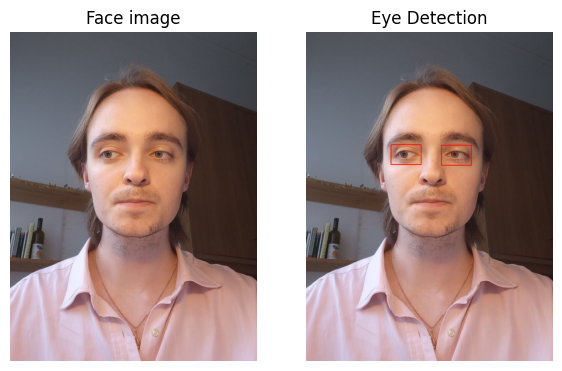

In [ ]:
Example = cv2.imread('L2.jpg')
Example_prepr = image_preproc(Example, 'rgb', (3,3))
Example_bounds, Example_le_cord, Example_re_cord, Example_h_e_x, Example_h_e_y, Example_r_ee = eyes_bounds(Example_prepr)

# 0. Display the image with eye
plt.figure(figsize = (7, 8))
plt.subplot(1,2,1)
plt.imshow(Example_prepr)
plt.axis('off')  # Hide axes
plt.title('Face image')
plt.subplot(1,2,2)
plt.imshow(Example_bounds)
plt.axis('off')  # Hide axes
plt.title('Eye Detection')

left eyes view vector  [-11, 0]
right eyes view vector  [-10, 5]


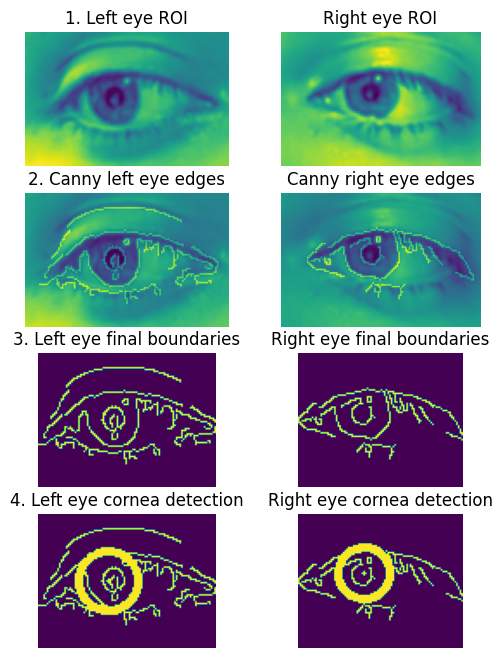

<Figure size 640x480 with 0 Axes>

In [ ]:
# 1. Rough ROI of eyes
# Left
Example_le = eye_ROI(Example_prepr, Example_le_cord, Example_h_e_x, Example_h_e_y)
Example_le = image_preproc(Example_le, 'gray', (3,3))
# Right
Example_re = eye_ROI(Example_prepr, Example_re_cord, Example_h_e_x, Example_h_e_y)
Example_re = image_preproc(Example_re, 'gray', (3,3))

# 2. Canny edges
# Left
Example_le_edges = cv2.Canny(Example_le, 50, 150)
Example_le_output = cv2.addWeighted(Example_le, 0.8, Example_le_edges, 0.2, 0)
# Right
Example_re_edges = cv2.Canny(Example_re, 50, 150)
Example_re_output = cv2.addWeighted(Example_re, 0.8, Example_re_edges, 0.2, 0)

# 3. ROI refining
# Left
Example_le_narrowed = eye_ROI_narrowed(Example_le)
# Right
Example_re_narrowed = eye_ROI_narrowed(Example_re)

# 4. Cornea detection by Hough Circles
Example_le_cornea_img, Example_le_pupil_img, Example_le_cornea_cord, Example_le_vector = cornea_detection(Example_le_narrowed, Example_r_ee)
Example_re_cornea_img, Example_re_pupil_img, Example_re_cornea_cord, Example_re_vector = cornea_detection(Example_re_narrowed, Example_r_ee)

plt.figure(figsize = (6, 8))

plt.subplot(4,2,1)
plt.imshow(Example_le)
plt.axis('off')
plt.title('1. Left eye ROI')
plt.subplot(4,2,2)
plt.imshow(Example_re)
plt.axis('off')
plt.title('Right eye ROI')

plt.subplot(4,2,3)
plt.imshow(Example_le_output)
plt.axis('off')
plt.title('2. Canny left eye edges')
plt.subplot(4,2,4)
plt.imshow(Example_re_output)
plt.axis('off')
plt.title('Canny right eye edges')

plt.subplot(4,2,5)
plt.imshow(Example_le_narrowed)
plt.axis('off')
plt.title('3. Left eye final boundaries')
plt.subplot(4,2,6)
plt.imshow(Example_re_narrowed)
plt.axis('off')
plt.title('Right eye final boundaries')

plt.subplot(4,2,7)
plt.imshow(Example_le_cornea_img)
plt.axis('off')
plt.title('4. Left eye cornea detection')

plt.subplot(4,2,8)
plt.imshow(Example_re_cornea_img)
plt.axis('off')
plt.title('Right eye cornea detection')

print('left eyes view vector ', Example_le_vector)
print('right eyes view vector ', Example_re_vector)


plt.show()
plt.tight_layout()

In [ ]:
edge = cv2.Canny(Example_le, 50, 150)
y_coords, x_coords = np.nonzero(edge)
edge_points = np.column_stack((x_coords, y_coords))
x_min = edge_points[:, 0].min()
x_max = edge_points[:, 0].max()
# y_min = edge_points[:, 1].min()
# y_max = edge_points[:, 1].max()
y_min = 0
# y_max = image.shape[0]
y_max = edge.shape[0]

edged_image = edge.copy()
# cv2.addWeighted(image, 0.8, edge, 0.2, 0)
cropped_image = edged_image[y_min:y_max, x_min:x_max]

plt.subplot(4,2,8)
plt.imshow(cropped_image)
plt.axis('off')
plt.title('Right eye cornea detection')

9 directions example

In [ ]:
# Directions of the eye

# Up Left
UL = cv2.imread('UL2.jpg')
UL_corneas, UL_view_vector, _ = pupil_detection(UL, (3,3))

# Up
U = cv2.imread('U2.jpg')
U_corneas, U_view_vector, _ = pupil_detection(U, (3,3))

# Up Right
UR = cv2.imread('UR2.jpg')
UR_corneas, UR_view_vector, _ = pupil_detection(UR, (3,3))

# Left
L = cv2.imread('L2.jpg')
L_corneas, L_view_vector, _ = pupil_detection(L, (3,3))

# Forward
F = cv2.imread('F2.jpg')
F_corneas, F_view_vector, _ = pupil_detection(F, (3,3))

# Right
R = cv2.imread('R2.jpg')
R_corneas, R_view_vector, _ = pupil_detection(R, (3,3))

# Down Left
DL = cv2.imread('DL2.jpg')
DL_corneas, DL_view_vector, _ = pupil_detection(DL, (3,3))

# Down
D = cv2.imread('D2.jpg')
D_corneas, D_view_vector, _ = pupil_detection(D, (3,3))

# Down RIght
DR = cv2.imread('DR2.jpg')
DR_corneas, DR_view_vector, _ = pupil_detection(DR, (3,3))

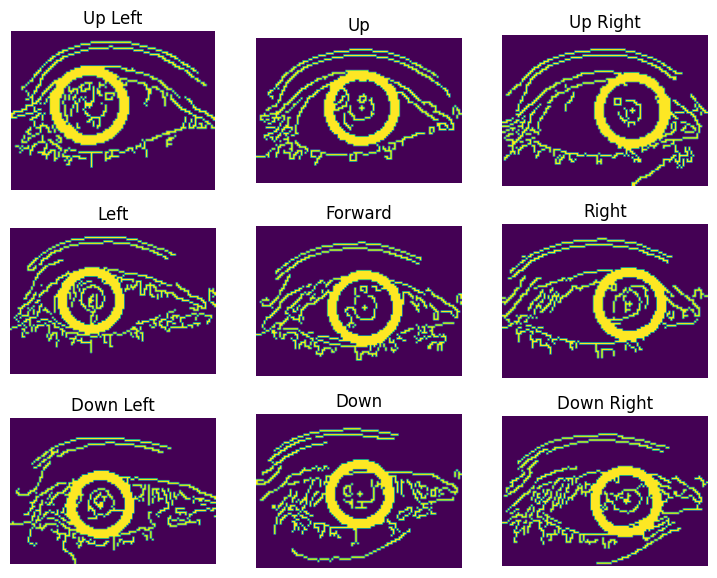

Left [-12, 3]
Up [1, 1]
Up Right [14, 0]
Left [-12, 0]
Forward [3, -3]
Right [12, -1]
Down Left [-7, -7]
Down [0, -1]
Down Right [11, -5]


<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize = (9, 7))

plt.subplot(3,3,1)
plt.imshow(UL_corneas[0])
plt.axis('off')
plt.title('Up Left')

plt.subplot(3,3,2)
plt.imshow(U_corneas[0])
plt.axis('off')
plt.title('Up')

plt.subplot(3,3,3)
plt.imshow(UR_corneas[0])
plt.axis('off')
plt.title('Up Right')

plt.subplot(3,3,4)
plt.imshow(L_corneas[0])
plt.axis('off')
plt.title('Left')

plt.subplot(3,3,5)
plt.imshow(F_corneas[0])
plt.axis('off')
plt.title('Forward')

plt.subplot(3,3,6)
plt.imshow(R_corneas[0])
plt.axis('off')
plt.title('Right')

plt.subplot(3,3,7)
plt.imshow(DL_corneas[0])
plt.axis('off')
plt.title('Down Left')

plt.subplot(3,3,8)
plt.imshow(D_corneas[0])
plt.axis('off')
plt.title('Down')

plt.subplot(3,3,9)
plt.imshow(DR_corneas[0])
plt.axis('off')
plt.title('Down Right')

plt.show()
plt.tight_layout()

print('Left', UL_view_vector)
print('Up', U_view_vector)
print('Up Right', UR_view_vector)
print('Left', L_view_vector)
print('Forward', F_view_vector)
print('Right', R_view_vector)
print('Down Left', DL_view_vector)
print('Down', D_view_vector)
print('Down Right', DR_view_vector)